In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用

import glob

In [2]:
# # train内にあるcsvのpathを取得
# train_path=glob.glob('/work/inputs/train/*.csv')
# train = pd.read_csv(train_path[0])
# #trainに結合
# for c in train_path:
#     train_df = pd.concat([train,pd.read_csv(c)])

In [3]:
#結合したcsvの書き出し
# train.to_csv('/work/inputs/train.csv')

In [4]:
train_df=pd.read_csv('/work/inputs/train.csv', converters={'間取り':str})
test_df=pd.read_csv('/work/inputs/test.csv')
sub_df=pd.read_csv('/work/inputs/sample_submission.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
INPUT_DIR = '/work/inputs/'
OUTPUT_DIR = '/work/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
from ptitprince import RainCloud

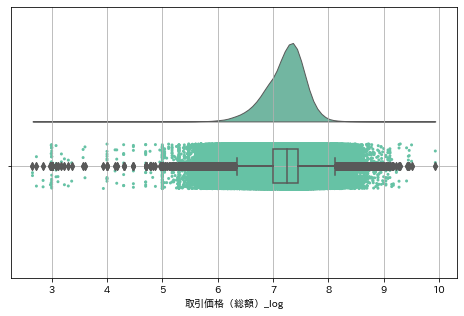

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
RainCloud(data=train_df, y='取引価格（総額）_log', orient='h', ax=ax)
ax.grid()

In [8]:
#これをするとdropした後のcolumを残すことになり特徴量に文字が入ってしまうので注意。
def drop_clum(input_df):
    use_columns = [
        '種類',
        '地域',
        '土地の形状',
        '間口',
        '延床面積（㎡）',
        '前面道路：方位',
        '前面道路：種類',
        '前面道路：幅員（ｍ）'
    ]
    return input_df.drop(use_columns, axis=1).copy()

In [9]:
def create_numeric_feature(input_df):
    use_columns = [
        '市区町村コード',
        '建ぺい率（％）',
        '容積率（％）'
    ]
    
    return input_df[use_columns].copy()

In [10]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()
    
    str_columns = [
        '都道府県名',
        '市区町村名',
        '地区名',
        '最寄駅：名称',
        '間取り',
        '建築年',
        '建物の構造',
        '用途',
        '今後の利用目的',
        '都市計画',
        '取引時点',
        '改装',
        '取引の事情等'
    ]
    
    for c in str_columns:
        out_df[c] = input_df[c].str.len()
        
    return out_df.add_prefix('StringLength__')

In [11]:
def create_count_encoding_feature(input_df):
    use_columns = [
        '都道府県名',
        '市区町村名',
        '地区名',
        '最寄駅：名称',
        '間取り',
        '建築年',
        '建物の構造',
        '用途',
        '今後の利用目的',
        '都市計画',
        '取引時点',
        '改装',
        '取引の事情等'
    ]
    
    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)
    
    return out_df.add_prefix('CE_')

In [12]:
def create_one_hot_encoding(input_df):
    use_columns = [
        '都道府県名',
        '市区町村名',
        '建築年',
        '建物の構造',
        '用途',
        '都市計画',
        '取引時点',
        '改装',
        '取引の事情等'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        
        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = train_df[column].value_counts()
        vc = vc[vc > 10000]
        
        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)
        
        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [13]:
# train_df['建築年'].unique()
# test_df['建築年'].map(test_df['建築年'].str.contains("戦前"))
test_df.groupby('建築年').size()

建築年
令和2年     126
平成10年    531
平成11年    475
平成12年    488
平成13年    478
平成14年    521
平成15年    545
平成16年    531
平成17年    594
平成18年    610
平成19年    647
平成20年    632
平成21年    510
平成22年    369
平成23年    435
平成24年    508
平成25年    449
平成26年    446
平成27年    343
平成28年    243
平成29年    197
平成2年     523
平成30年    164
平成31年    328
平成3年     583
平成4年     391
平成5年     278
平成6年     351
平成7年     522
平成8年     441
平成9年     451
戦前         3
昭和36年      1
昭和39年      4
昭和40年      4
昭和41年     12
昭和42年     24
昭和43年     50
昭和44年     56
昭和45年    134
昭和46年    124
昭和47年    133
昭和48年    222
昭和49年    359
昭和50年    192
昭和51年    151
昭和52年    154
昭和53年    191
昭和54年    232
昭和55年    203
昭和56年    212
昭和57年    232
昭和58年    195
昭和59年    362
昭和60年    325
昭和61年    323
昭和62年    345
昭和63年    400
昭和64年    451
dtype: int64

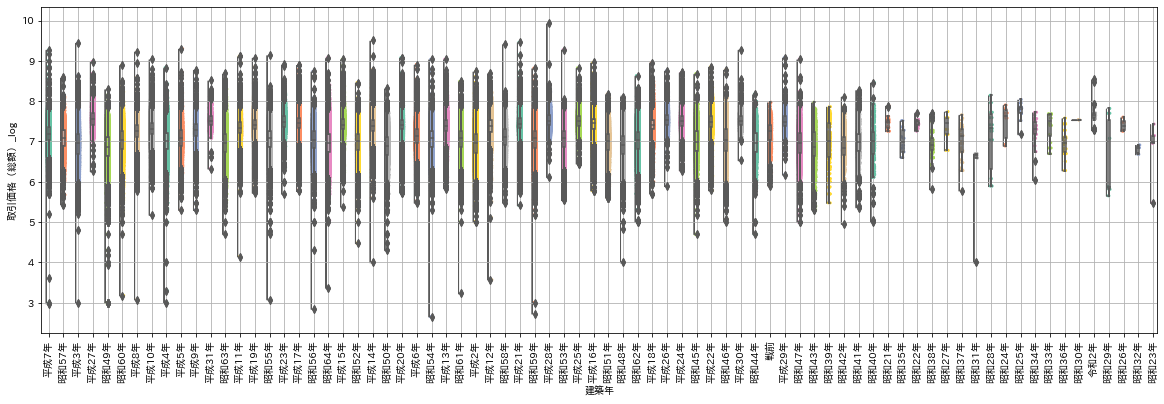

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
RainCloud(y=train_df['取引価格（総額）_log'], 
          x=train_df['建築年'], ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.grid()

In [15]:
test_df['建築年'].str.contains('平成')*1

0        0
1        1
2        0
3        1
4        0
        ..
19461    1
19462    1
19463    1
19464    1
19465    1
Name: 建築年, Length: 19466, dtype: object

In [16]:
pd.DataFrame({'A': [11, 21, 31],
                   'B': [12, 22, 32],
                   'C': [13, 23, 33]},
                  index=['ONE', 'TWO', 'THREE']).add_prefix('nengo_')

,nengo_A,nengo_B,nengo_C
ONE,11,12,13
TWO,21,22,23
THREE,31,32,33


In [17]:
def create_one_hot_encoding_nenngou(input_df):
    use_columns = [
        '建築年'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df['建築年_令和'] = input_df[column].str.contains('令和')*1
        out_df['建築年_平成'] = input_df[column].str.contains('平成')*1
        out_df['建築年_昭和'] = input_df[column].str.contains('昭和')*1
        out_df['建築年_戦前'] = input_df[column].str.contains('戦前')*1
    return out_df.add_prefix('nengo_')

In [18]:
create_one_hot_encoding_nenngou(test_df)

,nengo_建築年_令和,nengo_建築年_平成,nengo_建築年_昭和,nengo_建築年_戦前
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
19461,0,1,0,0
19462,0,1,0,0
19463,0,1,0,0
19464,0,1,0,0


In [19]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [20]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """
    
    processors = [
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_one_hot_encoding,
        create_one_hot_encoding_nenngou

    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [21]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

  0%|          | 0/5 [00:00<?, ?it/s]

createcreate_numeric_feature  0.014[s]


 40%|████      | 2/5 [00:08<00:12,  4.27s/it]

createcreate_string_length_feature  8.481[s]


 60%|██████    | 3/5 [00:14<00:10,  5.01s/it]

createcreate_count_encoding_feature  5.865[s]
createcreate_one_hot_encoding  4.654[s]


 80%|████████  | 4/5 [00:19<00:04,  4.99s/it]

createcreate_one_hot_encoding_nenngou  3.139[s]


  0%|          | 0/5 [00:00<?, ?it/s]

createcreate_numeric_feature  0.003[s]


 40%|████      | 2/5 [00:00<00:00,  9.63it/s]

createcreate_string_length_feature  0.201[s]


 60%|██████    | 3/5 [00:03<00:02,  1.25s/it]

createcreate_count_encoding_feature  2.858[s]


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

createcreate_one_hot_encoding  1.792[s]
createcreate_one_hot_encoding_nenngou  0.058[s]


In [22]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} MAE: {mean_absolute_error(y_valid, pred_i):.4f}')

    score = mean_absolute_error(y, oof_pred)
    print('-' * 50)
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

In [23]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'mae', 
    
     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,
    
    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,
    
    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 
    
    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 
    
    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 
    
    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,
    
    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,
    
    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [24]:
y = train_df['取引価格（総額）_log'].values

In [25]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 0.110903
[1000]	valid_0's l1: 0.104399
[1500]	valid_0's l1: 0.100951
[2000]	valid_0's l1: 0.098999
[2500]	valid_0's l1: 0.0975308
[3000]	valid_0's l1: 0.0966479
[3500]	valid_0's l1: 0.09587
[4000]	valid_0's l1: 0.0952954
[4500]	valid_0's l1: 0.0948775
[5000]	valid_0's l1: 0.0944659
[5500]	valid_0's l1: 0.0940991
[6000]	valid_0's l1: 0.0938186
[6500]	valid_0's l1: 0.0935581
[7000]	valid_0's l1: 0.0933184
[7500]	valid_0's l1: 0.0931067
[8000]	valid_0's l1: 0.0929266
[8500]	valid_0's l1: 0.0927792
[9000]	valid_0's l1: 0.0925961
[9500]	valid_0's l1: 0.0924285
[10000]	valid_0's l1: 0.0922836
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 0.0922836
fit fold=0  1895.861[s]
Fold 0 MAE: 0.0923
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

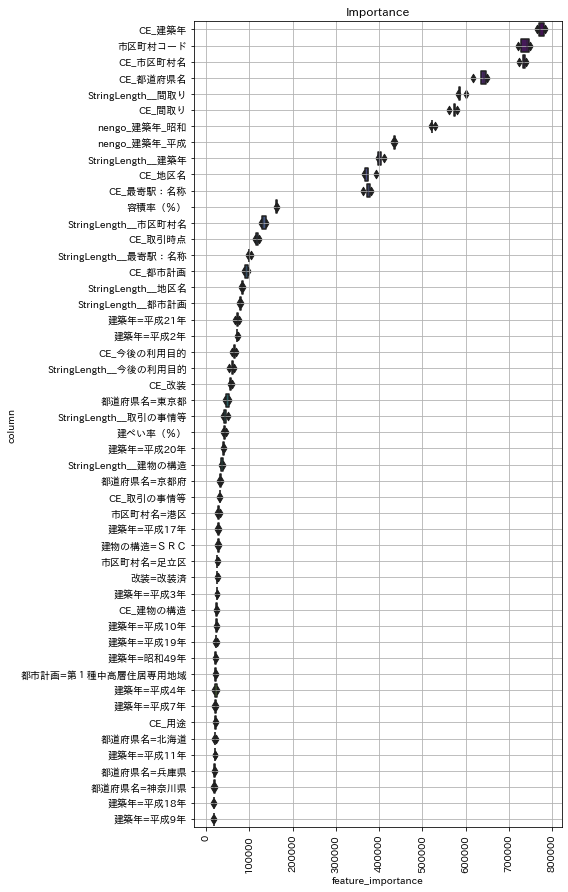

In [26]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

In [27]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
# pred = revert_to_real(pred)
sub_df_hoge = sub_df.copy()
sub_df_hoge['取引価格（総額）_log'] = pred
sub_df_hoge.to_csv(os.path.join(OUTPUT_DIR, '0003__submission.csv'), index=False)

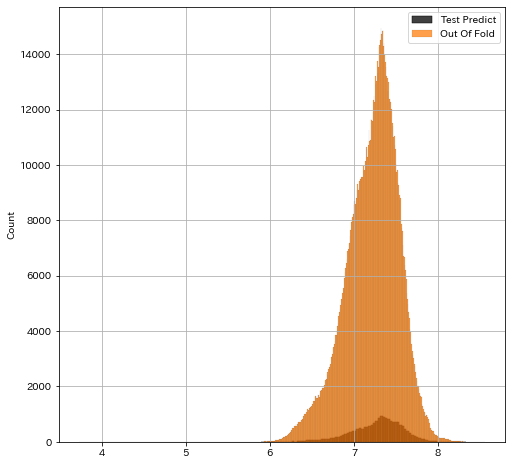

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(pred, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()